In [1]:
from fbprophet import Prophet

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Reading data

In [2]:
def evo_cleaning(data):
    # only travels with more than 30 minutes of duration, that is the limit of cancellation of a reserve
    data = data.loc[(data['duration'] > 30) | (data['distance'] > 3)]

    data.Start_time = pd.to_datetime(data.Start_time)
    data.End_time = pd.to_datetime(data.End_time)

    # Colleting vehicle ids
    car_ids = list(data.Id.unique())

    # Removing uncommon ids
    # Ex: 4c5865a3-4b03-40f6-a3a8-d4e94aae3b17
    ids_uncommon = [id for id in car_ids if id.find('-') != -1]
    car_ids = [id for id in car_ids if id.find('-') == -1]

    data = data.loc[~data.Id.isin(ids_uncommon)]
    
    # Removing microseconds from the dates
    data.Start_time = data.Start_time.apply(lambda x: x.replace(microsecond=0))
    data.End_time = data.End_time.apply(lambda x: x.replace(microsecond=0))
    
    return data

In [3]:
# reading data
evo_data = pd.read_csv('data/evo_travels.csv')
modo_data = pd.read_csv('data/modo_travels.csv')
c2g_data = pd.read_csv('data/car2go_travels.csv', index_col=0)

In [4]:
#cleaning process
evo_data = evo_cleaning(evo_data)

modo_data.start = modo_data.start.apply(lambda x: datetime.fromtimestamp(x))
modo_data.end = modo_data.end.apply(lambda x: datetime.fromtimestamp(x))

c2g_data.init_time = c2g_data.init_time.apply(lambda x: datetime.fromtimestamp(x))
c2g_data.final_time = c2g_data.final_time.apply(lambda x: datetime.fromtimestamp(x))

In [5]:
init_period = '05-25'
end_period = '06-15'

evo_data = evo_data[(evo_data.Start_time >= '2018-'+init_period) & (evo_data.End_time <= '2018-'+end_period)]
modo_data = modo_data[(modo_data.start >= '2018-'+init_period) & (modo_data.end <= '2018-'+end_period)]
c2g_data = c2g_data[(c2g_data.init_time >= '2017-'+init_period) & (c2g_data.final_time <= '2017-'+end_period)]

In [6]:
def to_prophet_data(time_list):
    """
        Convert a time series list to the prophet data structure
    """
    values = time_list.value_counts(sort=False)
    prophet_data = pd.DataFrame(list(zip(values.index, values)), columns=['ds','y'])
    prophet_data.sort_values(by='ds',inplace=True)
    prophet_data.reset_index(inplace=True, drop=True)
    
    return prophet_data

In [8]:
#prophet data structure

evo_prophet = to_prophet_data(evo_data.Start_time)
modo_prophet = to_prophet_data(modo_data.start)
c2g_prophet = to_prophet_data(c2g_data.init_time)

In [9]:
evo_prophet.head()

,ds,y
0,2018-05-25 04:21:11,1
1,2018-05-25 09:24:28,1
2,2018-05-25 11:09:17,1
3,2018-05-25 19:03:00,1
4,2018-05-25 20:48:19,1


## Train data used

In [10]:
def plot_time_points(data):
    fig, ax = plt.subplots(1,1)
    
    ax.scatter(data.ds, data.y, alpha=0.3)

    ax.set_xlim(data.ds.min(), data.ds.max())
    plt.xticks(rotation=45)
    
    plt.show()

### EVO

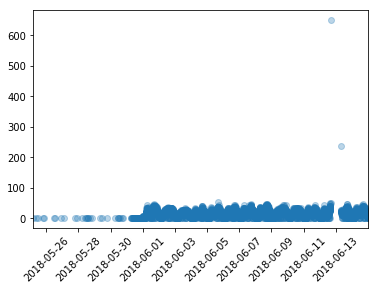

In [11]:
plot_time_points(evo_prophet)

### Modo

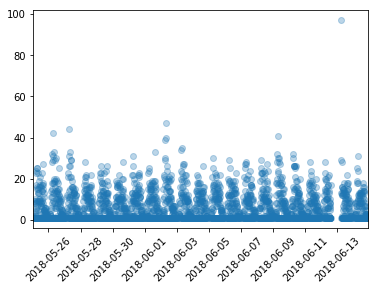

In [12]:
plot_time_points(modo_prophet)

### Car2Go

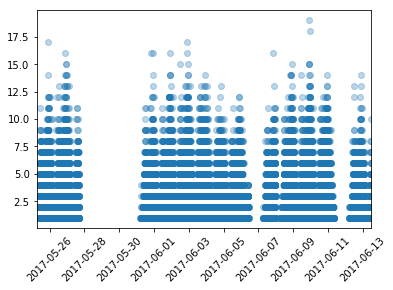

In [13]:
plot_time_points(c2g_prophet)

## Prophet forecast

In [13]:
def prophet_predict(data, freq='min', periods=5):
    model = Prophet(weekly_seasonality=True)
    model.fit(data)
    
    future = model.make_future_dataframe(freq=freq, periods=periods)
    
    forecast = model.predict(future)
    
    return model, forecast

In [27]:
PREDICT_PERIOD = 60*24  # One day
evo_model, evo_forecast = prophet_predict(evo_prophet, periods=PREDICT_PERIOD)
print('EVO done.')
modo_model, modo_forecast = prophet_predict(modo_prophet, periods=PREDICT_PERIOD)
print('Modo done.')
c2g_model, c2g_forecast = prophet_predict(c2g_prophet, periods=PREDICT_PERIOD)
print('Car2Go done.')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


EVO done.


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Modo done.
Car2Go done.


### EVO

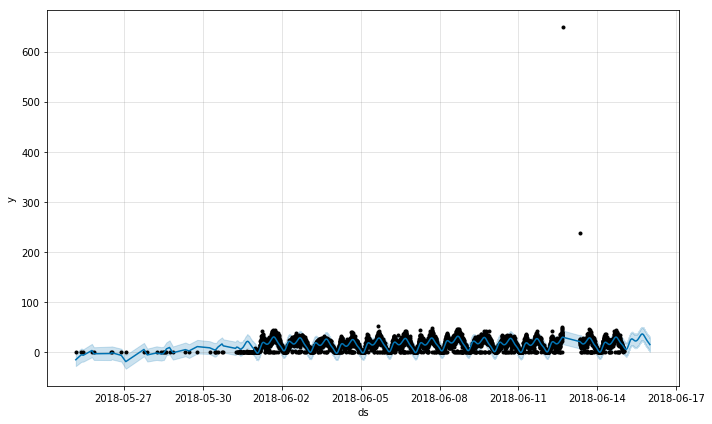

In [28]:
fig1 = evo_model.plot(evo_forecast)

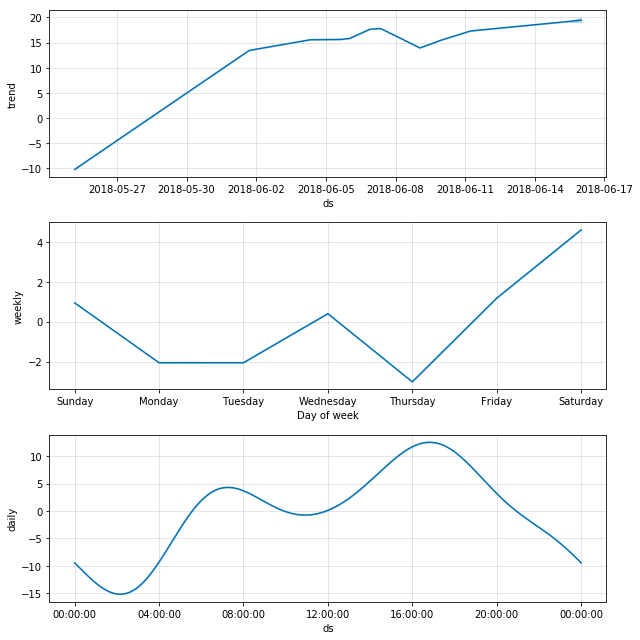

In [29]:
fig1 = evo_model.plot_components(evo_forecast)

### Modo

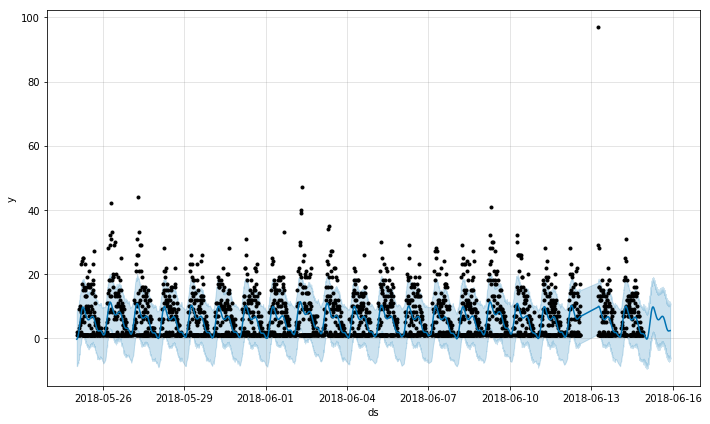

In [30]:
fig1 = modo_model.plot(modo_forecast)

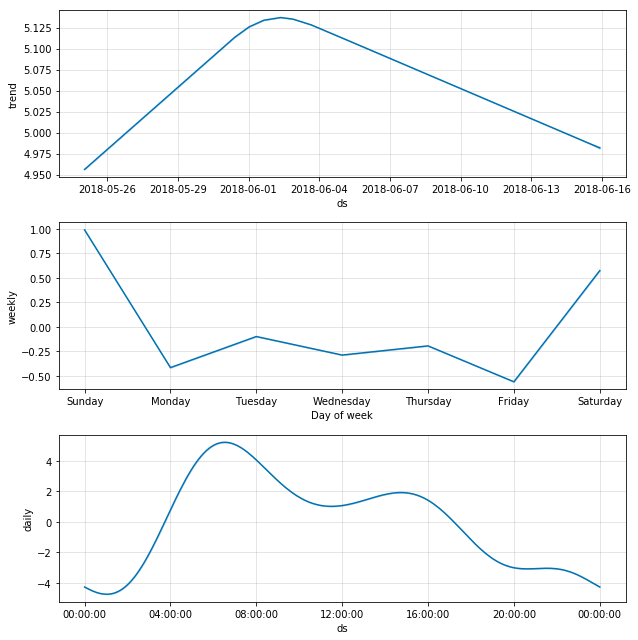

In [31]:
fig1 = modo_model.plot_components(modo_forecast)

### Car2Go

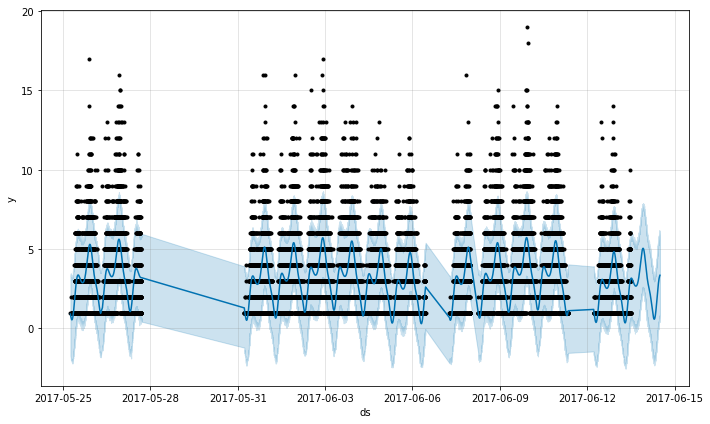

In [32]:
fig1 = c2g_model.plot(c2g_forecast)

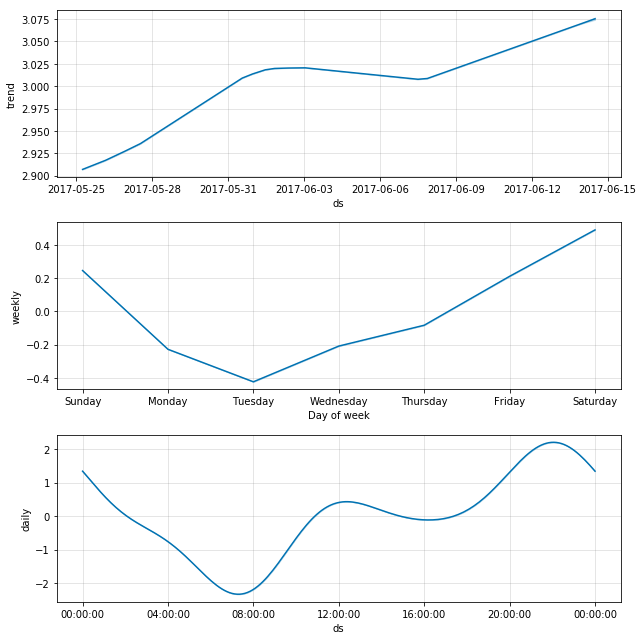

In [33]:
fig1 = c2g_model.plot_components(c2g_forecast)